# This notebook checks the results after a simulation

## init stuff

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import os
import glob
from result_utils.results_utils import xml2csv_path
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np

In [4]:
import sumolib

In [5]:
scenario = 'motorway'
path = f'../{scenario}/Results'


In [6]:
result_folders = os.listdir(path)

In [7]:
experiment_name = 'incident_only'
experiment_folders = [folder for folder in result_folders if folder.startswith(experiment_name)]

In [8]:
#experiment_folders

In [9]:
for folder in experiment_folders:
    result_xmls = [xml for xml in glob.glob(f'{path}/{folder}/*.xml') if 'log' not in xml]
    if len(glob.glob(f'{path}/{folder}/*.csv')) < len(result_xmls):
        print(f'Found fewer csv files than xml files in {folder}. Converting results')
        xml2csv_path(f'{path}/{folder}')
        print(f'finished converting {folder}')
    #else: print(f"All files in {folder} seems converted.")

# Load incident and net

In [10]:
#net_path = '../experiment/Simulations/Base/traci_exp.net.xml'
net_path = '../motorway/Simulations/Base/network.net.xml'
net = sumolib.net.readNet(net_path)

In [11]:
# 1 9
experiment = experiment_folders[13]
experiment_path = f'{path}/{experiment}'

print(experiment_path)
#os.listdir(experiment_path)

with open(f'{experiment_path}/incident_settings.json') as f:
    incident_settings = json.load(f)
print(incident_settings)

hours = incident_settings['start_time'] // 60 // 60
minutes = incident_settings['start_time'] // 60 % 60
seconds = incident_settings['start_time'] % 60
print(f'Incident at {hours}:{minutes}:{seconds}')

../motorway/Results/incident_only_counter_22
{'run_num': 22, 'is_incident': True, 'is_random': True, 'random_seed': 3691556750, 'edge': '360361373', 'lanes': [0, 1, 3], 'pos': 358.1722741760613, 'start_time': 67208, 'start_step': 134416, 'duration_time': 1140, 'duration_steps': 2280}
Incident at 18:40:8


In [12]:
incident_edge = incident_settings['edge']

In [13]:
incident_edge

'360361373'

In [14]:
i_edge_obj = net.getEdge(incident_edge)

In [15]:
n_up = 3
upstream_edges = {}
upstream_edges[0] = list(i_edge_obj.getIncoming().keys())

for i in range(0, n_up):
    print(i)
    next_edges = []
    for edge in upstream_edges[i]:
        next_edges += (list(edge.getIncoming().keys()))
    upstream_edges[i+1] = next_edges
    
upstream_edges_ids = {}
for i in range(0, n_up + 1):
    level_ids = []
    for edge in upstream_edges[i]:
        level_ids += [edge.getID()]
    upstream_edges_ids[i] = level_ids

0
1
2


In [16]:
upstream_edges

{0: [<edge id="360361373-AddedOnRampEdge" from="12532024" to="360361373-AddedOnRampNode"/>],
 1: [<edge id="22941416#1" from="386527" to="12532024"/>,
  <edge id="4937552#1" from="4937552#1-AddedOnRampNode" to="12532024"/>],
 2: [<edge id="22941416#0" from="247119713" to="386527"/>,
  <edge id="4937552#1-AddedOnRampEdge" from="312656342" to="4937552#1-AddedOnRampNode"/>],
 3: [<edge id="54121214" from="2187111852" to="247119713"/>,
  <edge id="28458824" from="288980861" to="312656342"/>,
  <edge id="4937552#0" from="26374688" to="312656342"/>]}

In [17]:
upstream_edges_ids

{0: ['360361373-AddedOnRampEdge'],
 1: ['22941416#1', '4937552#1'],
 2: ['22941416#0', '4937552#1-AddedOnRampEdge'],
 3: ['54121214', '28458824', '4937552#0']}

In [18]:
n_down = 3
downstream_edges = {}
downstream_edges[0] = list(i_edge_obj.getOutgoing().keys())

for i in range(0, n_down):
    print(i)
    next_edges = []
    for edge in downstream_edges[i]:
        next_edges += (list(edge.getOutgoing().keys()))
    downstream_edges[i+1] = next_edges
    
downstream_edges_ids = {}
for i in range(0, n_down + 1):
    level_ids = []
    for edge in downstream_edges[i]:
        level_ids += [edge.getID()]
    downstream_edges_ids[i] = level_ids

0
1
2


In [19]:
downstream_edges

{0: [<edge id="360361373.463" from="gneJ74" to="gneJ75"/>],
 1: [<edge id="360361373.981" from="gneJ75" to="gneJ70"/>],
 2: [<edge id="360361373.1498" from="gneJ70" to="gneJ69"/>],
 3: [<edge id="360361373.1899" from="gneJ69" to="gneJ66"/>]}

In [20]:
downstream_edges_ids

{0: ['360361373.463'],
 1: ['360361373.981'],
 2: ['360361373.1498'],
 3: ['360361373.1899']}

In [21]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [22]:
all_downstream_edges_ids = flatten(list(downstream_edges_ids.values()))
all_upstream_edges_ids = flatten(list(upstream_edges_ids.values()))

In [23]:
all_downstream_edges_ids

['360361373.463', '360361373.981', '360361373.1498', '360361373.1899']

In [24]:
all_upstream_edges_ids

['360361373-AddedOnRampEdge',
 '22941416#1',
 '4937552#1',
 '22941416#0',
 '4937552#1-AddedOnRampEdge',
 '54121214',
 '28458824',
 '4937552#0']

# Map

In [25]:
from matplotlib.collections import LineCollection  # noqa

In [26]:
#net_path = '../experiment/Simulations/Base/traci_exp.net.xml'
net_path = '../motorway/Simulations/Base/M50network.net.xml'
net = sumolib.net.readNet(net_path)

In [27]:
i_edge_obj.getBoundingBox()

(2897.45, 3008.91, 3160.83, 3389.95)

In [28]:
def plotNet(net, colors, widths, options, incident_edge_obj, ax):
    shapes = []
    c = []
    w = []
    for e in net._edges:
        shapes.append(e.getShape())
        if e._id in colors:
            c.append(colors[str(e._id)])
        else:
            c.append(options.defaultColor)
        if e._id in widths:
            w.append(widths[str(e._id)])
        else:
            w.append(options.defaultWidth)

    line_segments = LineCollection(shapes, linewidths=w, colors=c)
    ax = plt.gca()
    ax.add_collection(line_segments)
    ax.set_xmargin(0.1)
    ax.set_ymargin(0.1)
    
    (xmin, ymin, xmax, ymax) = incident_edge_obj.getBoundingBox()
    ax.set_xlim(xmin - 1200 ,xmax + 1200)
    ax.set_ylim(ymin - 1200 ,ymax + 1200)
    
    #ax.autoscale_view(True, True, True)
    return ax


In [29]:
from result_utils.dotdict import dotdict

In [30]:
plot_options = {'defaultColor': 'black',
                'defaultWidth': 1}
plot_options = dotdict(plot_options)

In [31]:
edge_colors = {incident_edge: 'red'}

In [32]:
for i in range(n_up):
    for id in upstream_edges_ids[i]:
        edge_colors[id] = 'orange'
        
for i in range(n_down):
    for id in downstream_edges_ids[i]:
        edge_colors[id] = 'blue'

<AxesSubplot:>

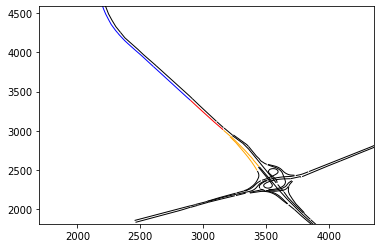

In [33]:
fig, ax = plt.subplots(1)
plotNet(net, edge_colors, {}, plot_options, i_edge_obj, ax)


## check counterfactuals

In [34]:
with open(f'{experiment_path}/incident_settings.json') as f:
    incident_settings = json.load(f)
incident_settings

{'run_num': 16,
 'is_incident': True,
 'is_random': True,
 'random_seed': 621860075,
 'edge': '328393125',
 'lanes': [1, 0, 2, 3],
 'pos': 202.78781363905966,
 'start_time': 73334,
 'start_step': 146668,
 'duration_time': 1315,
 'duration_steps': 2630}

In [35]:
results_incident = pd.read_csv(f'{experiment_path}/edgedata.csv', sep=';')
results_incident = results_incident[['edge_id', 'interval_begin', 'edge_density', 'edge_occupancy', 'edge_speed', 'edge_waitingTime', 'edge_timeLoss']]
results_incident_table = results_incident.pivot(index='edge_id', columns='interval_begin', values=['edge_speed','edge_density'])

counterfactual_incident = pd.read_csv(f'{experiment_path}/edgedata_counterfactual.csv', sep=';')
counterfactual_incident = counterfactual_incident[['edge_id', 'interval_begin', 'edge_density', 'edge_occupancy', 'edge_speed', 'edge_waitingTime', 'edge_timeLoss']]
counterfactual_incident_table = counterfactual_incident.pivot(index='edge_id', columns='interval_begin', values=['edge_speed','edge_density'])

In [36]:
relevant_edges = all_upstream_edges_ids + all_downstream_edges_ids + [incident_edge]

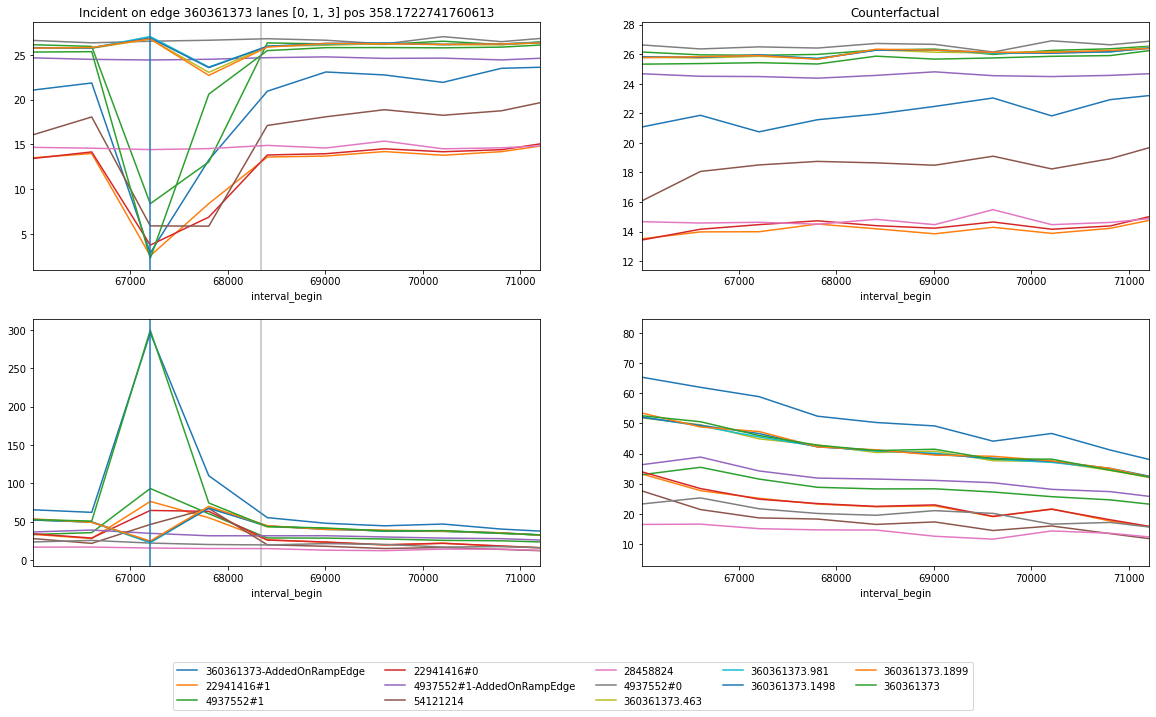

In [38]:
fig, ax = plt.subplots(2,2)

results_incident_table.loc[relevant_edges].edge_speed.T.plot(figsize=(20,10), ax=ax[0,0], legend=False)
ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')

results_incident_table.loc[relevant_edges].edge_density.T.plot(figsize=(20,10), ax=ax[1,0], legend=False)

counterfactual_incident_table.loc[relevant_edges].edge_speed.T.plot(figsize=(20,10), ax=ax[0,1], legend=False)
ax[0,1].set_title(f'Counterfactual')

counterfactual_incident_table.loc[relevant_edges].edge_density.T.plot(figsize=(20,10), ax=ax[1,1], legend=False)

ax[0,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 4000)
ax[1,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 4000)
ax[0,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 4000)
ax[1,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 4000)


ax[0,0].axvline(incident_settings['start_time'])
ax[1,0].axvline(incident_settings['start_time'])


ax[0,0].axvline(incident_settings['start_time'] + incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=5)